In [42]:
######## Read and retrive data from edf, video and csv file ########

import os
import numpy as np
import pandas as pd
import torch
import mne
import cv2
from torch.utils.data import Dataset
from config import config
from datetime import datetime
from scipy.signal import butter, filtfilt, iirnotch, sosfiltfilt, stft



class exp_times:
    manus_start_time = datetime.strptime('2023-10-02 14:59:20.799216', '%Y-%m-%d %H:%M:%S.%f')
    emg_start_time = datetime.strptime('2023-10-02 14:59:55.627000', '%Y-%m-%d %H:%M:%S.%f')
    video_Start_time = datetime.strptime('2023-10-02 14:59:55.628000', '%Y-%m-%d %H:%M:%S.%f')

def _filter_data(data: np.ndarray, fs: float, notch: float, low_freq: float, high_freq: float,
                     buff_len: int = 0) -> np.ndarray:
        """filter the data according to the pipeline

        Parameters
        ----------
        data : np.ndarray
            the data to filter, shape: (n_segments, n_channels, n_samples)

        Returns
        -------
        np.ndarray
            the filtered data, shape: (n_gestures, n_channels, n_samples - filter_buffer * sample_rate)
        """
        # notch filter design
        Q = 30  # Quality factor
        w0 = notch / (fs / 2)  # Normalized frequency
        b_notch, a_notch = iirnotch(w0, Q)

        # band pass filter design
        low_band = low_freq / (fs / 2)
        high_band = high_freq / (fs / 2)
        # create bandpass filter for EMG
        sos = butter(4, [low_band, high_band], btype='bandpass', output='sos')

        # apply filters using 'filtfilt' to avoid phase shift
        data = sosfiltfilt(sos, data, axis=2, padtype='even')
        data = filtfilt(b_notch, a_notch, data, axis=2, padtype='even')

        if buff_len > 0:
            data = data[:, :, buff_len:]
        return data

def read_edf_file(file_path):
    # function to read edf file
    # input: file path
    # output: raw data
    raw = mne.io.read_raw_edf(file_path, preload=True)

    #crop data before exp start time
    #convert to numpy array
    # raw = raw.get_data()

    return raw

def read_video_file(file_path):
    # function to read video file
    # input: file path
    # output: video data
    cap = cv2.VideoCapture(file_path)
    # crop video before exp start time
    cap.set(cv2.CAP_PROP_POS_MSEC, exp_times.video_Start_time)
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            frames.append(frame)
        else:
            break
    cap.release()
    return frames

def read_csv_file(file_path):
    # function to read csv file
    # input: file path
    # output: preprocessed csv data
    data = pd.read_csv(file_path)
    return data


In [2]:
video_path = 'dataset/video_2023-10-02 14-59-55-628.avi'
edf_path = 'dataset/test 2023-10-02 14-59-55-627.edf'
manus_path = 'dataset/Untitled_2023-10-02_15-24-12_YH_lab_R.csv'


### Read Manus Data

In [55]:
manus_data = read_csv_file(manus_path)
manus_data.head()

,Frame,Elapsed_Time_In_Milliseconds,Time,Hand_X,Hand_Y,Hand_Z,Thumb_CMC_X,Thumb_CMC_Y,Thumb_CMC_Z,Thumb_MCP_X,...,Middle_PIP_Flex_AngularAcceleration,Middle_DIP_Flex_AngularAcceleration,Ring_MCP_Spread_AngularAcceleration,Ring_MCP_Flex_AngularAcceleration,Ring_PIP_Flex_AngularAcceleration,Ring_DIP_Flex_AngularAcceleration,Pinky_MCP_Spread_AngularAcceleration,Pinky_MCP_Flex_AngularAcceleration,Pinky_PIP_Flex_AngularAcceleration,Pinky_DIP_Flex_AngularAcceleration
0,0,0,00:00:00:000,0,0,0,-15.37808,-0.101900,-35.77632,-9.460745,...,88857.550,56502.140,-160253.8000,456826.000,33636.99,21314.180,-222560.400,597647.60,104916.30,65949.660
1,1,8,00:00:00:008,0,0,0,-15.37808,-0.101900,-35.77632,-9.460745,...,-88857.550,-56502.140,160253.8000,-456826.000,-33636.99,-21314.180,222560.400,-597647.60,-104916.30,-65949.660
2,2,16,00:00:00:016,0,0,0,-15.37808,-0.101900,-35.77632,-9.460745,...,0.000,0.000,0.0000,0.000,0.00,0.000,0.000,0.00,0.00,0.000
3,3,24,00:00:00:024,0,0,0,-15.06695,-0.281111,-35.90751,-8.933857,...,-4448.062,-2819.112,-603.2318,-17278.060,-14889.48,-9427.975,-9785.590,-36534.48,-20287.08,-12720.830
4,4,32,00:00:00:032,0,0,0,-14.75991,-0.462951,-36.03293,-8.409499,...,-4325.777,-2755.271,674.8351,782.199,10659.13,6746.107,4930.705,16323.81,10138.86,6350.701


In [57]:
#convert Time column to datetime with manus_start_time as reference
manus_data['Time'] = pd.to_datetime(manus_data['Elapsed_Time_In_Milliseconds'], unit='ms', origin=exp_times.manus_start_time)
manus_data = manus_data[manus_data['Time'] >= exp_times.emg_start_time]
manus_data.drop(columns=['Elapsed_Time_In_Milliseconds','Time'], inplace=True)
ch_names = manus_data.columns

#filter ch_names for acceleration and values using regex


KeyError: 'Elapsed_Time_In_Milliseconds'

In [58]:
acc_ch = [ch for ch in ch_names if 'Acc' in ch]
vel_ch = [ch for ch in ch_names if 'Vel' in ch]
print(len(acc_ch), len(vel_ch))

95 95


In [54]:
# convert the to np array
# manus_data = manus_data.to_numpy()
# manus_data.shape
ch_names = [ str(i) for i in range(len(manus_data[1]))]
info = mne.create_info(ch_names=ch_names, sfreq=120, ch_types='emg',)
raw = mne.io.RawArray(manus_data.T, info)
raw.plot()

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [5]:
#set the index to time
manus_data.set_index('Time', inplace=True)
manus_data.head()

,Frame,Elapsed_Time_In_Milliseconds,Hand_X,Hand_Y,Hand_Z,Thumb_CMC_X,Thumb_CMC_Y,Thumb_CMC_Z,Thumb_MCP_X,Thumb_MCP_Y,...,Middle_PIP_Flex_AngularAcceleration,Middle_DIP_Flex_AngularAcceleration,Ring_MCP_Spread_AngularAcceleration,Ring_MCP_Flex_AngularAcceleration,Ring_PIP_Flex_AngularAcceleration,Ring_DIP_Flex_AngularAcceleration,Pinky_MCP_Spread_AngularAcceleration,Pinky_MCP_Flex_AngularAcceleration,Pinky_PIP_Flex_AngularAcceleration,Pinky_DIP_Flex_AngularAcceleration
Time,,,,,,,,,,,,,,,,,,,,,
2023-10-02 14:59:20.799,0,0,0,0,0,-15.37808,-0.101900,-35.77632,-9.460745,7.300410,...,88857.550,56502.140,-160253.8000,456826.000,33636.99,21314.180,-222560.400,597647.60,104916.30,65949.660
2023-10-02 14:59:20.807,1,8,0,0,0,-15.37808,-0.101900,-35.77632,-9.460745,7.300410,...,-88857.550,-56502.140,160253.8000,-456826.000,-33636.99,-21314.180,222560.400,-597647.60,-104916.30,-65949.660
2023-10-02 14:59:20.815,2,16,0,0,0,-15.37808,-0.101900,-35.77632,-9.460745,7.300410,...,0.000,0.000,0.0000,0.000,0.00,0.000,0.000,0.00,0.00,0.000
2023-10-02 14:59:20.823,3,24,0,0,0,-15.06695,-0.281111,-35.90751,-8.933857,7.025779,...,-4448.062,-2819.112,-603.2318,-17278.060,-14889.48,-9427.975,-9785.590,-36534.48,-20287.08,-12720.830
2023-10-02 14:59:20.831,4,32,0,0,0,-14.75991,-0.462951,-36.03293,-8.409499,6.737466,...,-4325.777,-2755.271,674.8351,782.199,10659.13,6746.107,4930.705,16323.81,10138.86,6350.701


In [30]:
# crop the data before emg_start_time

manus_data.shape

(164650, 366)

In [33]:
# read emg data
emg_data = read_edf_file(edf_path)
emg_data.info

Extracting EDF parameters from /Users/rufaelmarew/Documents/tau/project/Generalised_FGR_using_EMG/dataset/test 2023-10-02 14-59-55-627.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345249  =      0.000 ...  1380.996 secs...


<Info | 7 non-empty values
 bads: []
 ch_names: Channel 0, Channel 1, Channel 2, Channel 3, Channel 4, Channel ...
 chs: 22 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2023-10-02 14:59:55 UTC
 nchan: 22
 projs: []
 sfreq: 250.0 Hz
>

In [34]:
emg_data.resample(sfreq=125, npad="auto")
emg_data.info

<Info | 7 non-empty values
 bads: []
 ch_names: Channel 0, Channel 1, Channel 2, Channel 3, Channel 4, Channel ...
 chs: 22 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 62.5 Hz
 meas_date: 2023-10-02 14:59:55 UTC
 nchan: 22
 projs: []
 sfreq: 125.0 Hz
>

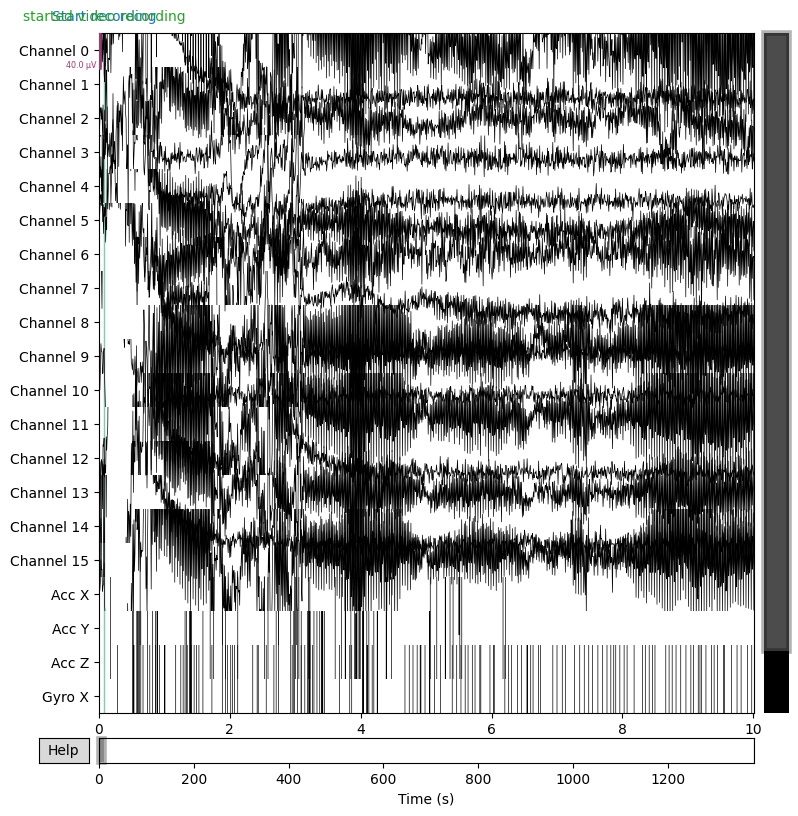

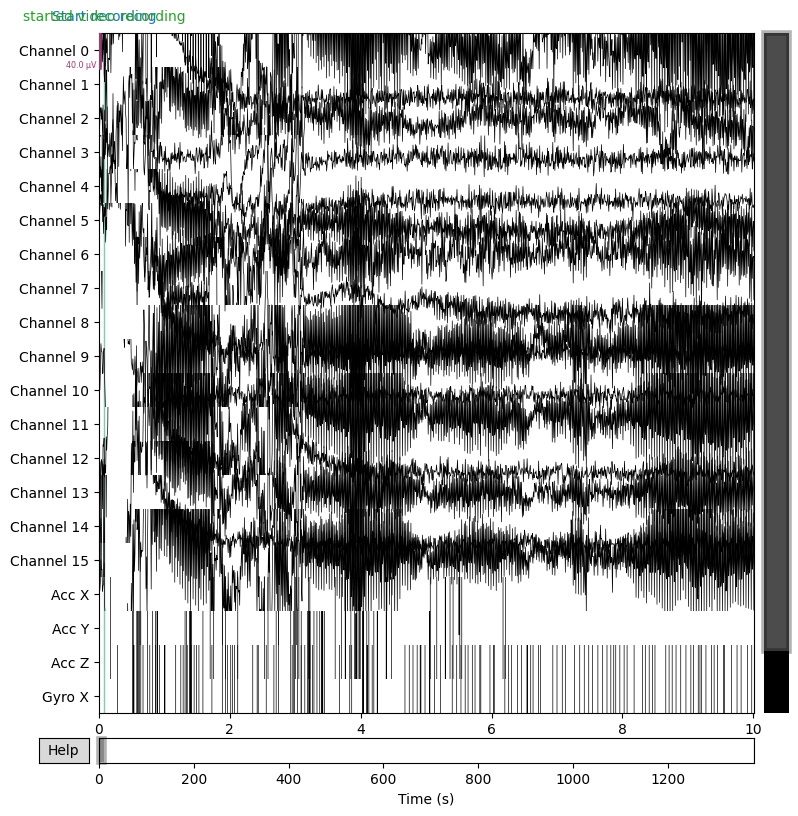

In [35]:
emg_data.plot()

In [37]:
emg_data.filter(l_freq=50, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 50.00
- Lower transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 43.75 Hz)
- Filter length: 33 samples (0.264 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.4s finished


<RawEDF | test 2023-10-02 14-59-55-627.edf, 22 x 172625 (1381.0 s), ~29.0 MB, data loaded>

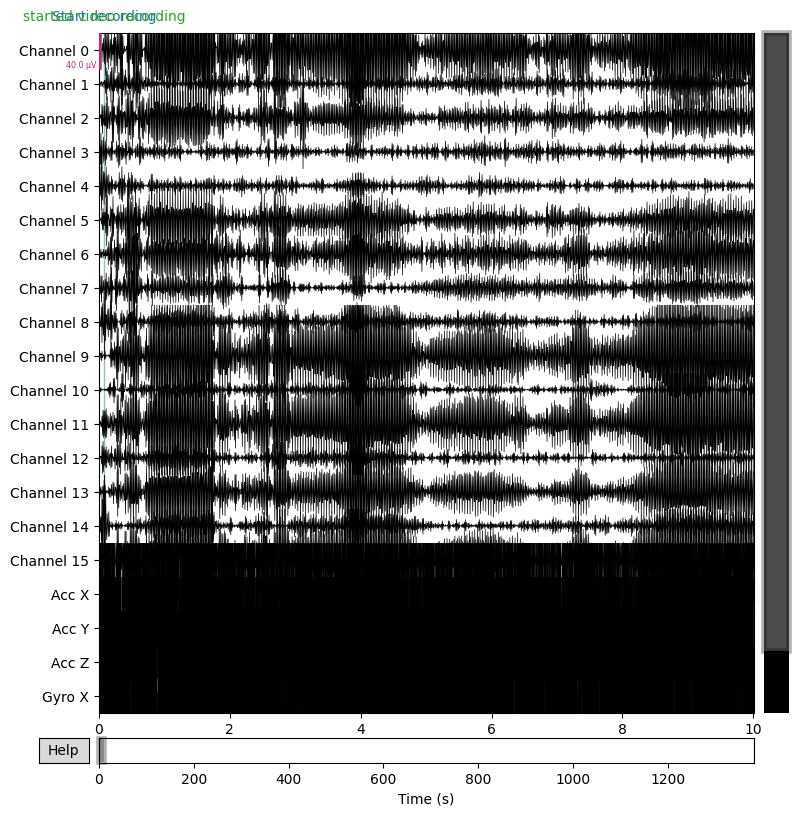

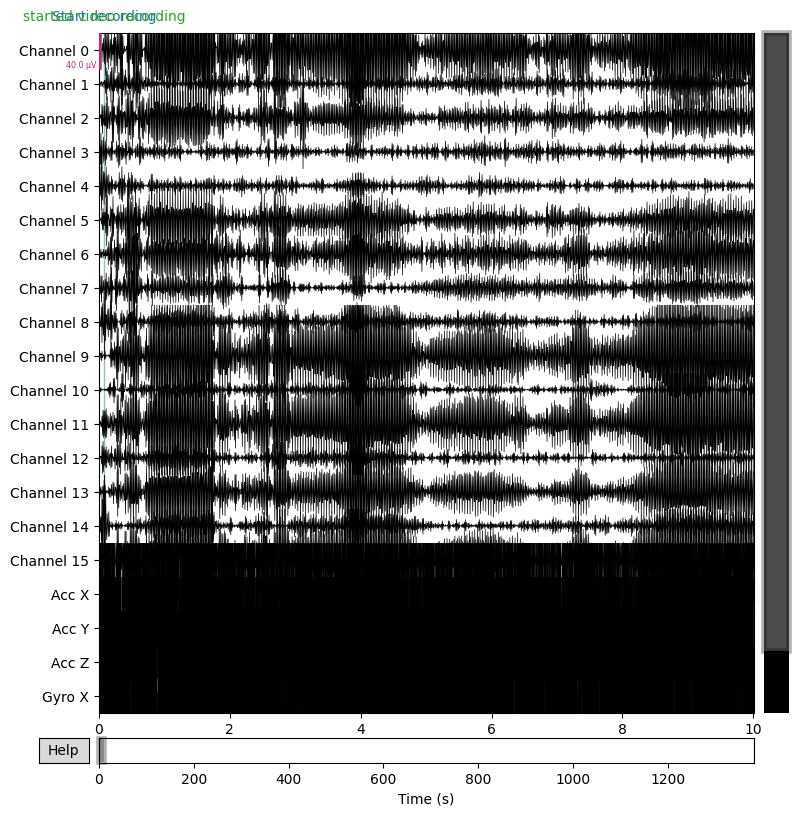

In [41]:
emg_data.plot()
